In [42]:
import pandas as pd
import random
import ast
import numpy as np
import scipy.stats as stats 
import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, glob
import pickle
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
from adjustText import adjust_text
from sklearn.preprocessing import StandardScaler
plt.rcParams["font.family"] = "Times New Roman"

In [2]:
# change current working directory to the base
os.chdir('../')
os.getcwd()

'/Users/xehu/Desktop/Team Process Mapping/tpm-horse-race-modeling'

# Get Key Files

### Full Multi-Task Data
Here, there is one row per stage. Each row explains how a particular team did on a particular task with a particular complexity.

In [3]:
# full multi-task data
full_multi_task_data = pd.read_csv('../tpm-data/raw_data/full_multi_task_data.csv').rename(columns={"task": "task_name"})
full_multi_task_data = full_multi_task_data.groupby('stageId').apply(lambda x: x.loc[x['score'].idxmax()]).reset_index(drop=True)
full_multi_task_data.head()

,task_name,complexity,stageId,playerCount,score
0,Writing Story,Medium,22bJZWfgB3gfKXY6A,6,100.000000
1,Writing Story,Low,22wFrSqgf8ESM8pNY,3,100.000000
2,Divergent Association,Medium,24uBQrHu4jKFgGQ24,1,83.248037
3,Moral Reasoning,High,26RnwcdY842ZGSQtT,3,50.000000
4,Room Assignment,High,28b6Y5xQDcrdFZK2h,1,88.659794


### Task Map

In [4]:
# task map
task_map = pd.read_csv('./features/task-mapping/task_map.csv')
task_map = task_map.rename(columns = {"task": "task_name"})

In [5]:
task_name_mapping = {
    "Sudoku": "Sudoku",
    "Moral Reasoning": "Moral Reasoning (Disciplinary Action Case)",
    "Wolf Goat Cabbage": "Wolf, goat and cabbage transfer",
    "Guess the Correlation": "Guessing the correlation",
    "Writing Story": "Writing story",
    "Room Assignment": "Room assignment task",
    "Allocating Resources": "Allocating resources to programs",
    "Divergent Association": "Divergent Association Task",
    "Word Construction": "Word construction from a subset of letters",
    "Whac a Mole": "Whac-A-Mole"
}

In [6]:
# make the names match
full_multi_task_data.loc[:, "task_name"] = full_multi_task_data["task_name"].replace(task_name_mapping)

## Get Team Data

In [7]:
complexity_columns = ["High", "Low", "Medium"]

full_multi_task_data["team"] = np.where(full_multi_task_data["playerCount"] > 1, True, False)
team_multi_task_data = full_multi_task_data[full_multi_task_data["team"] == True]
grouped_performance_by_task = pd.DataFrame(team_multi_task_data.groupby(["task_name", "complexity", "playerCount"])["score"].agg("mean")).reset_index()
grouped_performance_by_task = pd.get_dummies(grouped_performance_by_task, columns = ["complexity"]).rename(columns = {"complexity_High": "High", "complexity_Low": "Low", "complexity_Medium": "Medium"})
grouped_performance_by_task[complexity_columns] = grouped_performance_by_task[complexity_columns].astype(int)
### This is main data DF --
grouped_performance_with_task_cols = pd.merge(left = grouped_performance_by_task, right = task_map, on = "task_name", how = "left")

### Stage-based data

For teams, here we get information on:
- Player Composition
- Communication (chat) features

In [8]:
# read in some scores from one of our pickle files
# NOTE: the noncumulative version slices by the STAGE, which means we get the discussion relevant to the task complexity as well
with open("./data_cache/multi_task_stageId_noncumulative_nonstandardized.pkl", "rb") as cleaned_pickle_file:
	stage_based_data = pickle.load(cleaned_pickle_file)

In [9]:
targets = stage_based_data.dvs
tasks = stage_based_data.task_name

# Get a sense of how many observations we have

In [10]:
full_multi_task_data.groupby(["task_name", "complexity"]).size().reset_index(name='num_observations')

,task_name,complexity,num_observations
0,Allocating resources to programs,High,107
1,Allocating resources to programs,Low,107
2,Allocating resources to programs,Medium,107
3,Divergent Association Task,High,79
4,Divergent Association Task,Low,86
5,Divergent Association Task,Medium,82
6,Guessing the correlation,High,108
7,Guessing the correlation,Low,110
8,Guessing the correlation,Medium,109
9,Moral Reasoning (Disciplinary Action Case),High,103


# Calculate Synergy
> take score and for every team choose a random group of individuals of the same team size, then from that group select the best individual and a random individual.

> Synergy is then:

> strong if the team is better than the best individual

> weak if the team is not better than the best individual but better than the random one


In [11]:
individual_multi_task_data = full_multi_task_data[full_multi_task_data["team"]==False]
individual_multi_task_data.head()

,task_name,complexity,stageId,playerCount,score,team
2,Divergent Association Task,Medium,24uBQrHu4jKFgGQ24,1,83.248037,False
4,Room assignment task,High,28b6Y5xQDcrdFZK2h,1,88.659794,False
5,"Wolf, goat and cabbage transfer",High,297T4k8D3YuCqKYgk,1,0.000000,False
6,"Wolf, goat and cabbage transfer",Medium,2AnaRvyyBhKYYz3bv,1,43.000000,False
8,Allocating resources to programs,Medium,2DLuipD5F9zFmC3BP,1,90.000000,False


In [12]:
def get_nominal_team(task_name, complexity, playerCount):
    individuals_for_task_and_complexity = individual_multi_task_data[(individual_multi_task_data["task_name"] == task_name) & (individual_multi_task_data["complexity"] == complexity)]
    return individuals_for_task_and_complexity.sample(n = playerCount, replace = True)

In [13]:
def get_best_and_random_individual(task_name, complexity, playerCount):
    nominal_team_scores = get_nominal_team(task_name, complexity, playerCount)["score"]
    return(np.max(nominal_team_scores), random.choice(list(nominal_team_scores)))

In [14]:
grouped_performance_with_task_cols["strong_synergy"] = np.zeros(len(grouped_performance_with_task_cols))
grouped_performance_with_task_cols["weak_synergy"] = np.zeros(len(grouped_performance_with_task_cols))

for i, row in grouped_performance_with_task_cols.iterrows():
    task_name = row["task_name"]
    if row["High"] == 1:
        complexity = "High"
    elif row["Medium"] == 1:
        complexity = "Medium"
    else:
        complexity = "Low"
    playerCount = row["playerCount"]
    average_team_score = row["score"]

    best_individual_scores = []
    random_individual_scores = []
    for j in range(1000): # bootstrap 1,000 times
        best_score, random_score = get_best_and_random_individual(task_name, complexity, playerCount)
        best_individual_scores.append(best_score)
        random_individual_scores.append(random_score)

    # update the original dataframe
    grouped_performance_with_task_cols.loc[i, "strong_synergy"] = average_team_score / np.mean(best_individual_scores)
    grouped_performance_with_task_cols.loc[i, "weak_synergy"] = average_team_score / np.mean(random_individual_scores)

In [15]:
# this now has strong and weak synergy
grouped_performance_with_task_cols.head()


,task_name,playerCount,score,High,Low,Medium,Q1concept_behav,Q3type_1_planning,Q4type_2_generate,Q6type_5_cc,...,Q20type_3_type_4,Q22confl_tradeoffs,Q23ss_out_uncert,Q24eureka_question,Q2intel_manip_1,Q21intellective_judg_1,Q5creativity_input_1,Q25_type6_mixed_motive,strong_synergy,weak_synergy
0,Allocating resources to programs,3,69.032258,1,0,0,0.0,0.44,0.36,1.0,...,0.08,0.96,0.36,0.0,0.036,0.196,0.48,0,0.786692,1.196192
1,Allocating resources to programs,6,63.076923,1,0,0,0.0,0.44,0.36,1.0,...,0.08,0.96,0.36,0.0,0.036,0.196,0.48,0,0.658148,1.057805
2,Allocating resources to programs,3,61.290323,0,1,0,0.0,0.44,0.36,1.0,...,0.08,0.96,0.36,0.0,0.036,0.196,0.48,0,0.702347,1.165769
3,Allocating resources to programs,6,58.076923,0,1,0,0.0,0.44,0.36,1.0,...,0.08,0.96,0.36,0.0,0.036,0.196,0.48,0,0.594137,1.141898
4,Allocating resources to programs,3,63.709677,0,0,1,0.0,0.44,0.36,1.0,...,0.08,0.96,0.36,0.0,0.036,0.196,0.48,0,0.793791,1.406395


## Exploratory Heatmap Plots

In [16]:
task_cols = task_map.drop("task_name", axis = 1).columns

In [17]:
def plot_correlation_heatmap(correlation_matrix, y_cols, feature_name):
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(correlation_matrix)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(task_cols)))
    ax.set_xticklabels(task_cols, rotation=45, ha="right")

    ax.set_yticks(np.arange(len(y_cols)), labels=y_cols)

    ax.set_title("Correlation Between " + feature_name + " & Task Feature")

    # Add shorter and horizontal colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.15, shrink = 0.6)
    cbar.set_label('Correlation')

    fig.tight_layout()
    plt.show()

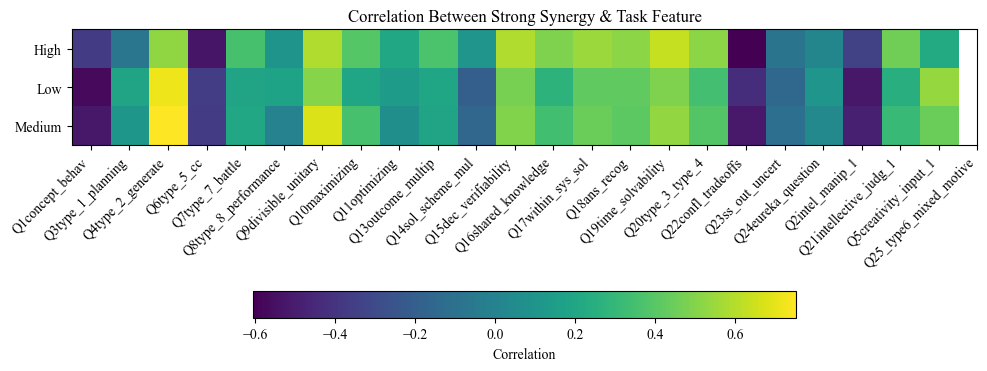

In [18]:
synergy_to_task_correlation = []

for complexity in ["Low", "Medium", "High"]:
    synergy_by_task_for_complexity = grouped_performance_with_task_cols[grouped_performance_with_task_cols[complexity]==1]
    within_complexity_arr = []
    for col in task_map.drop(["task_name", "Q25_type6_mixed_motive"], axis=1).columns:
        correlation = np.corrcoef(synergy_by_task_for_complexity["strong_synergy"], synergy_by_task_for_complexity[col])[0][1]
        within_complexity_arr.append(correlation)

    synergy_to_task_correlation.append(within_complexity_arr)
plot_correlation_heatmap(synergy_to_task_correlation, complexity_columns, "Strong Synergy")

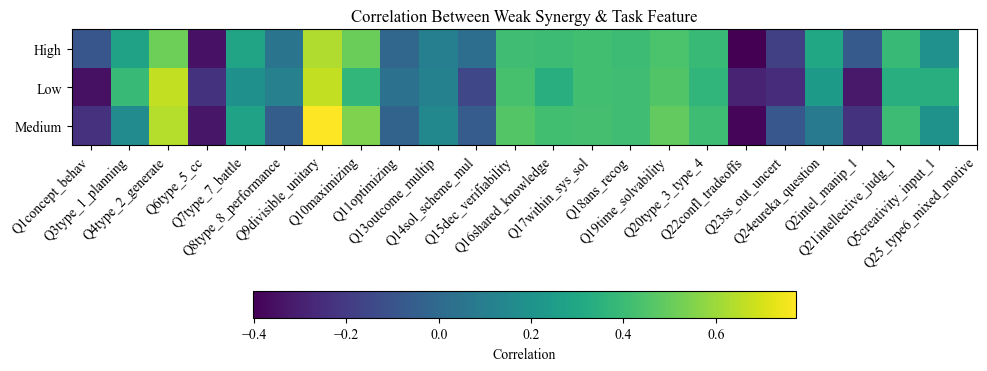

In [19]:
synergy_weak_to_task_correlation = []

for complexity in ["Low", "Medium", "High"]:
    synergy_by_task_for_complexity = grouped_performance_with_task_cols[grouped_performance_with_task_cols[complexity]==1]
    within_complexity_arr = []
    for col in task_map.drop(["task_name", "Q25_type6_mixed_motive"], axis=1).columns:
        correlation = np.corrcoef(synergy_by_task_for_complexity["weak_synergy"], synergy_by_task_for_complexity[col])[0][1]
        within_complexity_arr.append(correlation)

    synergy_weak_to_task_correlation.append(within_complexity_arr)
plot_correlation_heatmap(synergy_weak_to_task_correlation, complexity_columns, "Weak Synergy")

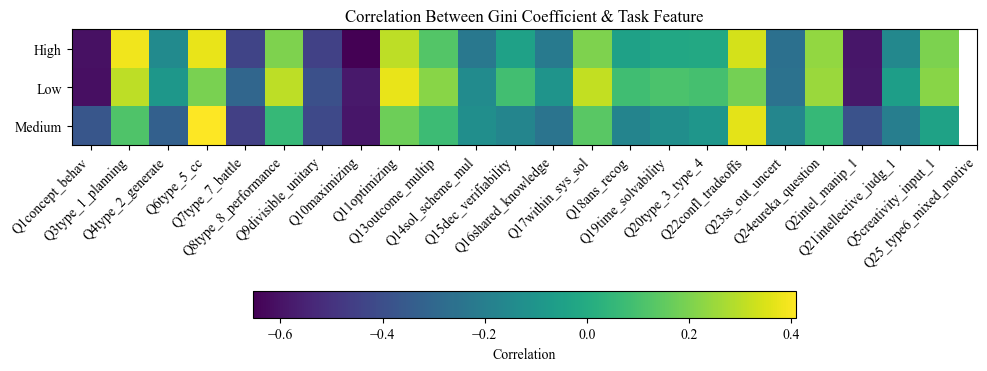

In [20]:
df_gini_messages = stage_based_data.data[["gini_coefficient_sum_num_messages", "task", "complexity", "score", "playerCount"]].groupby(["task", "complexity", "playerCount"])["gini_coefficient_sum_num_messages"].agg("mean").reset_index()

gini_to_task_correlation = []

for complexity in ["Low", "Medium", "High"]:
    gini_data_for_complexity = df_gini_messages[df_gini_messages["complexity"] == complexity]
    team_data_for_complexity = grouped_performance_with_task_cols[grouped_performance_with_task_cols[complexity]==1]
    within_complexity_arr = []
    for col in task_map.drop(["task_name", "Q25_type6_mixed_motive"], axis=1).columns:
        correlation = np.corrcoef(gini_data_for_complexity["gini_coefficient_sum_num_messages"], team_data_for_complexity[col])[0][1]
        within_complexity_arr.append(correlation)

    gini_to_task_correlation.append(within_complexity_arr)

plot_correlation_heatmap(gini_to_task_correlation, complexity_columns, "Gini Coefficient")

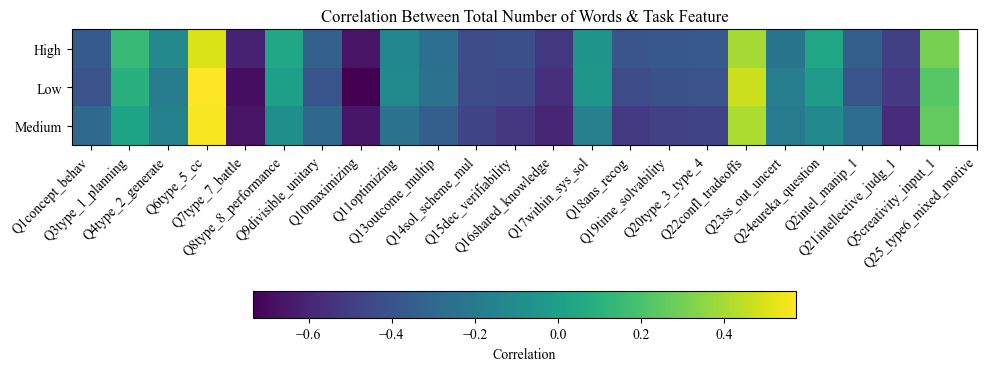

In [88]:
df_sum_words_messages = stage_based_data.data[["sum_num_words", "task", "complexity", "score", "playerCount"]].groupby(["task", "complexity", "playerCount"])["sum_num_words"].agg("mean").reset_index()

sum_num_words_to_task_correlation = []

for complexity in ["Low", "Medium", "High"]:
    sum_num_words_data_for_complexity = df_sum_words_messages[df_sum_words_messages["complexity"] == complexity]
    team_data_for_complexity = grouped_performance_with_task_cols[grouped_performance_with_task_cols[complexity]==1]
    within_complexity_arr = []
    for col in task_map.drop(["task_name", "Q25_type6_mixed_motive"], axis=1).columns:
        correlation = np.corrcoef(sum_num_words_data_for_complexity["sum_num_words"], team_data_for_complexity[col])[0][1]
        within_complexity_arr.append(correlation)

    sum_num_words_to_task_correlation.append(within_complexity_arr)

plot_correlation_heatmap(sum_num_words_to_task_correlation, complexity_columns, "Total Number of Words")

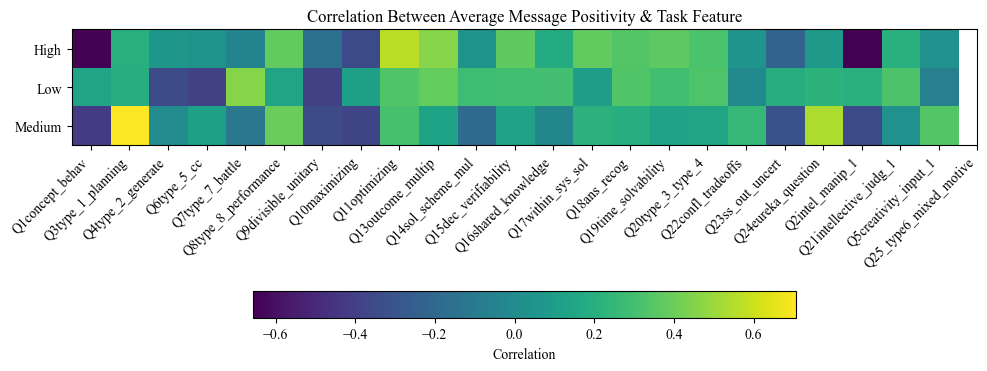

In [21]:
df_positivity_messages = stage_based_data.data[["average_positive_bert", "task", "complexity", "score", "playerCount"]].groupby(["task", "complexity", "playerCount"])["average_positive_bert"].agg("mean").reset_index()

positivity_to_task_correlation = []

for complexity in ["Low", "Medium", "High"]:
    positivity_data_for_complexity = df_positivity_messages[df_positivity_messages["complexity"] == complexity]
    team_data_for_complexity = grouped_performance_with_task_cols[grouped_performance_with_task_cols[complexity]==1]
    within_complexity_arr = []
    for col in task_map.drop(["task_name", "Q25_type6_mixed_motive"], axis=1).columns:
        correlation = np.corrcoef(positivity_data_for_complexity["average_positive_bert"], team_data_for_complexity[col])[0][1]
        within_complexity_arr.append(correlation)

    positivity_to_task_correlation.append(within_complexity_arr)

plot_correlation_heatmap(positivity_to_task_correlation, complexity_columns, "Average Message Positivity")

## Recreation of PCA Plot (Figure 4) with Real Data

In [96]:
task_cols_to_use = task_map.drop(["task_name", "Q25_type6_mixed_motive"], axis = 1).columns

In [97]:
grouped_avg_all_tasks = grouped_performance_with_task_cols.groupby("task_name").agg("mean").reset_index()

In [98]:
# Normalize task columns
normalized_df = grouped_avg_all_tasks.copy()
normalized_df[task_cols_to_use] = normalized_df[task_cols_to_use].transform(lambda x: (x - x.mean()) / x.std())

pca = PCA(n_components=2)
pca_for_multitask_data = pca.fit_transform(normalized_df[task_cols_to_use])

In [99]:
pca_df = pd.DataFrame(data=pca_for_multitask_data, columns=["PC1", "PC2"])

In [100]:
# dependent variables of interest
pca_df["synergy"] = grouped_avg_all_tasks["strong_synergy"]
pca_df["gini_coefficient"] = df_gini_messages.groupby("task")["gini_coefficient_sum_num_messages"].agg("mean").reset_index()["gini_coefficient_sum_num_messages"]
pca_df["total_words"] = df_sum_words_messages.groupby("task")["sum_num_words"].agg("mean").reset_index()["sum_num_words"]


# concatenate task names so that they can be included as labels
pca_df = pd.concat([pca_df, grouped_avg_all_tasks["task_name"]], axis=1)

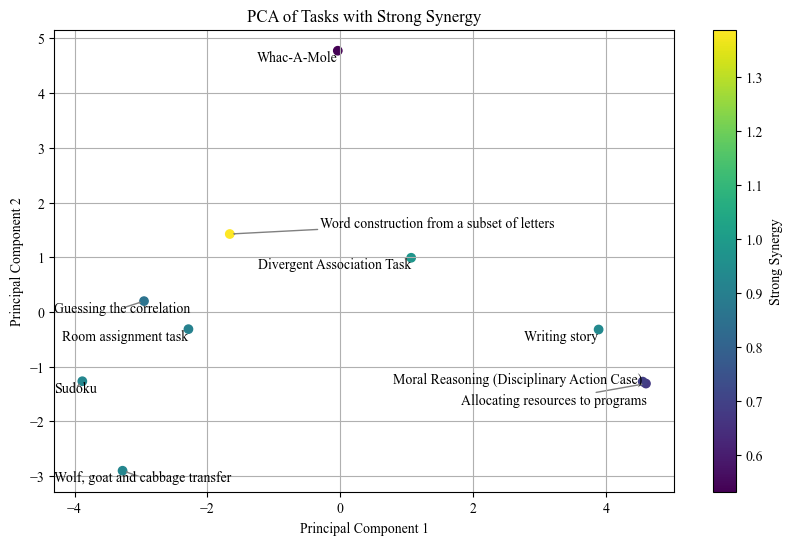

In [101]:
def plot_pca_scatter_with_labels(pca_df, dv, dv_label):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(pca_df["PC1"], pca_df["PC2"], c=pca_df[dv])

    plt.title("PCA of Tasks with " + dv_label)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")

    cbar = plt.colorbar(scatter, label=dv_label)

    texts = []
    for i, txt in enumerate(pca_df["task_name"]):
        texts.append(plt.text(pca_df["PC1"].iloc[i], pca_df["PC2"].iloc[i], txt, ha='left'))

    # adjust text labels to avoid overlap
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

    plt.grid(True)

    plt.show()

plot_pca_scatter_with_labels(pca_df, dv = "synergy", dv_label="Strong Synergy")

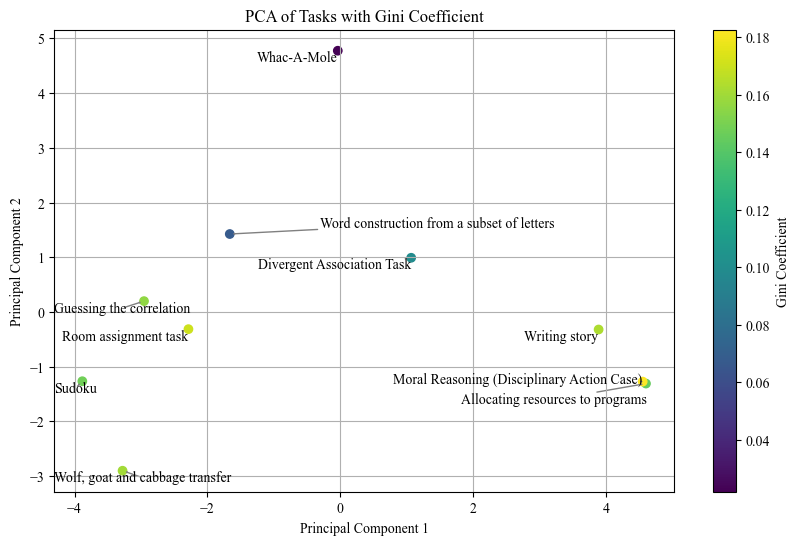

In [102]:
plot_pca_scatter_with_labels(pca_df, dv = "gini_coefficient", dv_label="Gini Coefficient")

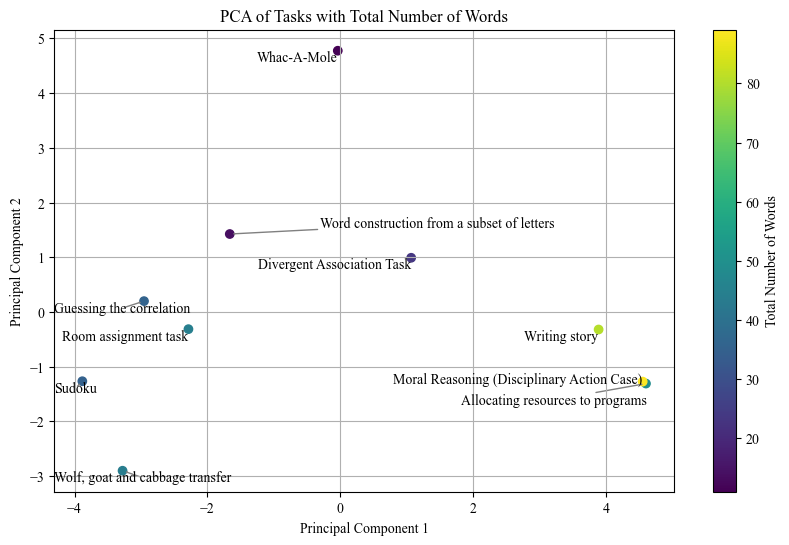

In [103]:
plot_pca_scatter_with_labels(pca_df, dv = "total_words", dv_label="Total Number of Words")